# HW03 - Automatic differentiation from scratch
In this practical, our aim is to understand how Pytorch performs automatic differentiation by making **our very own pytorch library**! To do so, we will reimplement the `backward()` function of PyTorch using NumPy only. This method will be able to backpropagate the gradients through any computation graph made of simple functions and store the gradient of the loss for each input parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from PIL import Image
import IPython.display as display

# Part A - Creating the computation graph

Create a `Tensor` class that contains three fields: a numpy array `data` containing the value of the tensor, a set `_parents` that contains the parent nodes (i.e. Tensors) in the computation graph, and a string `_function` that contains the name of the function used to compute it (if any). The `__init__` method should only take `data` as input, and set `_function` and `_parents` to default values (`None` and `set()`, respectively). Add a `__repr__` function to print the value of tensors in a proper format.

In [2]:
### YOUR CODE HERE ###
class Tensor:
    def __init__(self,data):
        self.data = data #assumed to be a numpy array
        self._function = None
        self._parents = set()
    def __repr__(self):
        return f"Tensor({self.data})"

tensor = Tensor(np.array([[1, 2], [3, 4]]))
print(tensor)


Tensor([[1 2]
 [3 4]])


Write functions `add(tensor1, tensor2)` and `mul(tensor1, tensor2)` that perform addition and multiplication of tensors, and properly update the value of the output tensor's hidden fields (`_function` and `_parents`). We will assume, for simplicity, that tensors are only scalars at this point. Test your functions on simple examples.

In [3]:
### YOUR CODE HERE ###
def add(tensor1,tensor2):
    out = Tensor(tensor1.data + tensor2.data)
    out._function = "add"
    out._parents = {tensor1, tensor2}
    return out

def mul(tensor1, tensor2):
    out = Tensor(tensor1.data * tensor2.data)
    out._function = "mul"
    out._parents = {tensor1, tensor2}
    return out

# example
tensor1 = Tensor(np.array([1, 2, 3]))
tensor2 = Tensor(np.array([4, 5, 6]))

add_tensor = add(tensor1, tensor2)
mul_tensor = mul(tensor1, tensor2)

print(f"Added Tensor: {add_tensor}, Function: {add_tensor._function}, Parents: {[repr(p) for p in add_tensor._parents]}")
print(f"Multiplied Tensor: {mul_tensor}, Function: {mul_tensor._function}, Parents: {[repr(p) for p in mul_tensor._parents]}")

Added Tensor: Tensor([5 7 9]), Function: add, Parents: ['Tensor([1 2 3])', 'Tensor([4 5 6])']
Multiplied Tensor: Tensor([ 4 10 18]), Function: mul, Parents: ['Tensor([1 2 3])', 'Tensor([4 5 6])']


Now overload the operators `+` and `*` for tensors with your own functions (see e.g. https://docs.python.org/3/library/operator.html). Test it on simple examples.

In [4]:
### YOUR CODE HERE ###
Tensor.__add__ = add
Tensor.__mul__ = mul

# example
tensor1 = Tensor(np.array([1, 2, 3]))
tensor2 = Tensor(np.array([4, 5, 6]))

add_tensor = tensor1 + tensor2
mul_tensor = tensor1 * tensor2

print(f"Added Tensor: {add_tensor}, Function: {add_tensor._function}, Parents: {[repr(p) for p in add_tensor._parents]}")
print(f"Multiplied Tensor: {mul_tensor}, Function: {mul_tensor._function}, Parents: {[repr(p) for p in mul_tensor._parents]}")

Added Tensor: Tensor([5 7 9]), Function: add, Parents: ['Tensor([4 5 6])', 'Tensor([1 2 3])']
Multiplied Tensor: Tensor([ 4 10 18]), Function: mul, Parents: ['Tensor([4 5 6])', 'Tensor([1 2 3])']


Write the `trace_graph` function that returns a list of all nodes and edges (i.e. pairs of nodes) in the computation graph.

In [5]:
def trace_graph(tensor):
    """
    Trace the computational graph starting from a tensor.
    Returns the nodes and edges of the graph.
    """
    nodes, edges = set(), set()

    ### YOUR CODE HERE ###
    queue = [tensor]

    while queue:
        current_tensor = queue.pop(0)
        if current_tensor not in nodes:
            nodes.add(current_tensor)
            for parent in current_tensor._parents:
                edges.add((parent, current_tensor))
                if parent not in nodes:
                    queue.append(parent)

    return nodes, edges

In [6]:
def draw_computation_graph(tensor):
    """
    Plot the computation graph starting from a given tensor.
    """
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})  # Left-to-right layout

    # Trace the graph and get nodes and edges
    nodes, edges = trace_graph(tensor)

    for node in nodes:
        node_label = node._function if node._function else f"{np.linalg.norm(node.data):.2f}"
        # Add node to the graph, label with its value
        dot.node(str(id(node)), label=node_label, shape='circle')

    for n1, n2 in edges:
        # Create edges between nodes
        dot.edge(str(id(n1)), str(id(n2)))

    # Render and display the graph
    graph_path = dot.render(filename='computation-graph')
    img = Image.open(graph_path)
    display.display(img)

Test the visualization tool with the
function $x^2 + 4x + 2$.

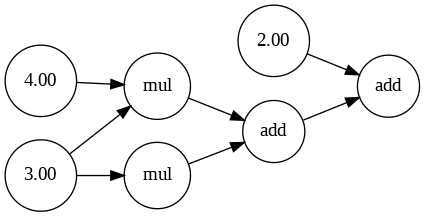

In [7]:
### YOUR CODE HERE ###

x = Tensor(3)  # let x be 3
x_squared = x * x
four_x = Tensor(4) * x
polynomial = x_squared + four_x + Tensor(2)

draw_computation_graph(polynomial)

# Part B - The backpropagation algorithm

We will implement backpropagation by using tensors as nodes of the computation graph. To do so, each function used during the computation will add a `_backward` method to its output tensor. The purpose of this method is to update the gradient (`grad`) of the function's input tensors according to the chain rule (see the new `add` function below). Modify `mul` accordingly.

In [8]:
def add(tensor1, tensor2):
    out = Tensor(tensor1.data + tensor2.data)

    def _backward():
        tensor1.grad = tensor1.grad + out.grad
        tensor2.grad = tensor2.grad + out.grad

    out._backward = _backward
    out._function = "add"
    out._parents = {tensor1, tensor2}

    return out

### YOUR CODE HERE ###

def mul(tensor1, tensor2):
    out = Tensor(tensor1.data * tensor2.data)
    def _backward():
        tensor1.grad = tensor1.grad + out.grad * tensor2.data
        tensor2.grad = tensor2.grad + out.grad * tensor1.data
    out._backward = _backward
    out._function = "mul"
    out._parents = {tensor1, tensor2}
    return out

Add the logarithm and exponential functions.

In [9]:
### YOUR CODE HERE ###
def log(tensor):
    out = Tensor(np.log(tensor.data))
    def _backward():
        tensor.grad = tensor.grad + out.grad / tensor.data

    out._backward = _backward
    out._function = "log"
    out._parents = {tensor}
    return out

def exp(t):
    out = Tensor(np.exp(t.data))
    def _backward():
        t.grad = t.grad + out.grad * np.exp(t.data)

    out._backward = _backward
    out._function = "exp"
    out._parents = {t}
    return out

Now extend the `Tensor` class to also contains the fields:

1.   `grad` (default value: `None`) that will contain, after calling `backward()`, the gradient of the output with respect to this tensor.
2.   `_backward` (default value: `lambda: None`) that will implement the chain rule for the function whose output is this tensor.

Finally add a method `backward(self)` that implements the backpropagation algorithm. To do so:

1. Build a list of tensors (i.e. nodes of the computation graph) that contains all nodes, from the current tensor (generally the final output or loss) to the roots (the input tensors or parameters in a learning setting), and such that parents appear after their children in the list.
2. Initialize all nodes' gradients `node.grad` to zero.
3. Initialize the current tensor's gradient `self.grad` to one.
4. Apply the `node._backward()` function for each node in the list.

To test your backpropagation algorithm, compute the gradient of $x*x + 5x - 1$ at $x=2$ and verify that the result is indeed $9$.

In [10]:
### YOUR CODE HERE ###

class Tensor:
    def __init__(self, data):
        self.data = data
        self._function = None
        self._parents = set()
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Tensor({self.data})"

    def backward(self):
        sorted_nodes = []
        visited = set()

        def dfs(node):
            if node not in visited:
                visited.add(node)
                for parent in node._parents:
                    dfs(parent)
                sorted_nodes.append(node)

        dfs(self)
        sorted_nodes.reverse()

        for node in sorted_nodes:
            node.grad = 0

        self.grad = 1

        for node in sorted_nodes:
            node._backward()

Tensor.__add__ = add
Tensor.__mul__ = mul

x = Tensor(2.0)
x2 = x * x
five_x = Tensor(5.0) * x
y = x2 + five_x + Tensor(-1.0)

y.backward()
print(f"Gradient of x for  x*x + 5*x - 1 at x = 2: {x.grad}")


Gradient of x for  x*x + 5*x - 1 at x = 2: 9.0


# Part C - Optimization with gradient descent

Now that we have implemented automatic differentiation, use it to perform gradient descent on the function $f(x) = x^2 + 5x - 1$, and verify that GD with a small step-size converges to $x^*=-5/2$. Then, test on the more complex function $f(x) = log(1+e^{-x}) + log(1+e^{2x^2})$, and verify that GD with a small step-size converges to $x^*=0.2136$.

In [11]:
def neg(tensor):
    out = Tensor(-tensor.data)
    out._function = 'neg'
    out._parents.add(tensor)
    def _backward():
        tensor.grad -= out.grad
    out._backward = _backward
    return out
Tensor.__neg__ = neg

In [12]:
### YOUR CODE HERE ###

def gradient_descent(initial_x, function, epochs, learning_rate):
    x = Tensor(initial_x)
    for epoch in range(epochs):
        x.grad = 0
        y = function(x)
        y.backward()
        x.data -= learning_rate * x.grad
        #print(f"Epoch {epoch + 1}: x = {x.data}, f(x) = {y.data}, grad = {x.grad}")
    return x.data

def func1(x):
    return x * x + Tensor(5.0) * x + Tensor(-1.0)

def func2(x):
    term1 = log(Tensor(1) + exp(-x))
    term2 = log(Tensor(1) + exp(Tensor(2) * x * x))
    return term1 + term2

initial_x = 0.0
epochs = 50
learning_rate = 0.1
final_x = gradient_descent(initial_x, func1, epochs, learning_rate)
print(f"Final x after gradient descent on func1: {final_x}")

initial_x = 0.0
epochs = 350    #the second function requires more epochs to converge
learning_rate = 0.1
final_x = gradient_descent(initial_x, func2, epochs, learning_rate)
print(f"Final x after gradient descent on func2: {final_x}")

Final x after gradient descent on func1: -2.4999643188076823
Final x after gradient descent on func2: 0.21364944942102596


# Part D - Matrix and regression setting (optional)
Update the code to allow for matrix-vector products and the ReLU function, and test it on a regression problem with a 2-layer MLP.